In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
from sklearn.utils import shuffle

In [3]:
dataset=pd.read_csv('normalised_english_reviews.csv')
dataset=shuffle(dataset)

In [4]:
reviews=dataset['text'].tolist()
labels=dataset['polarity'].tolist()

In [5]:
vocab_size=5100
tokenizer=tfds.features.text.SubwordTextEncoder.build_from_corpus(reviews,vocab_size,max_subword_length=4)
print("Vocab size is",tokenizer.vocab_size)

Vocab size is 5030


In [6]:
for i,sentence in enumerate(reviews):
    reviews[i]=tokenizer.encode(sentence)

In [7]:
max_length  = 50
trunc_type='post'
padding_type='post'
reviews_padded = pad_sequences(reviews,maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_size=int(len(reviews)*0.8)
validation_end=int(len(reviews))

training_reviews=reviews_padded[0:training_size]
training_labels=labels[0:training_size]
validation_reviews=reviews_padded[training_size:validation_end]
validation_labels=labels[training_size:validation_end]
testing_reviews=np.array(reviews_padded[validation_end:])
testing_labels=labels[validation_end:]

training_reviews_final=np.array(training_reviews)
validation_reviews_final=np.array(validation_reviews)
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)
testing_labels_final = np.array(testing_labels)


In [8]:
embedding_dim=5

model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 5)             25500     
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 10)            440       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10)                640       
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 26,677
Trainable params: 26,677
Non-trainable params: 0
_________________________________________________________________


In [12]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10)
num_epochs=100
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(training_reviews_final,training_labels_final,epochs=num_epochs,validation_data=(validation_reviews_final,validation_labels_final),callbacks=[es])

Train on 3402 samples, validate on 851 samples
Epoch 1/100
3402/3402 [==============================] - 11s 3ms/sample - loss: 0.3062 - accuracy: 0.5952 - val_loss: 0.6881 - val_accuracy: 0.5006
Epoch 2/100
3402/3402 [==============================] - 4s 1ms/sample - loss: 0.2997 - accuracy: 0.5947 - val_loss: 0.7347 - val_accuracy: 0.5159
Epoch 3/100
3402/3402 [==============================] - 4s 1ms/sample - loss: 0.2985 - accuracy: 0.5955 - val_loss: 0.8114 - val_accuracy: 0.5253
Epoch 4/100
3402/3402 [==============================] - 4s 1ms/sample - loss: 0.2955 - accuracy: 0.5955 - val_loss: 0.8530 - val_accuracy: 0.5065
Epoch 5/100
3402/3402 [==============================] - 4s 1ms/sample - loss: 0.2938 - accuracy: 0.5952 - val_loss: 0.8456 - val_accuracy: 0.5206
Epoch 6/100
3402/3402 [==============================] - 4s 1ms/sample - loss: 0.2972 - accuracy: 0.5961 - val_loss: 0.8340 - val_accuracy: 0.5147
Epoch 7/100
3402/3402 [==============================] - 4s 1ms/sample

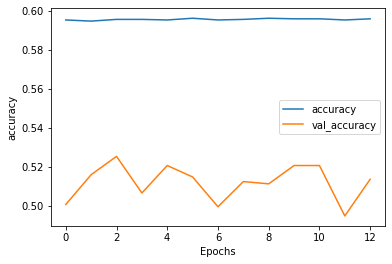

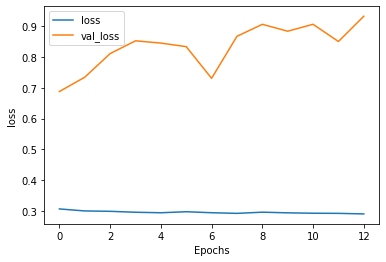

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
         
  
    new_sequences = [] 
    for i, frvw in enumerate(new_sentences):
        new_sequences.append(tokenizer.encode(frvw))
    trunc_type='post' 
    padding_type='post'

    new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

    classes = model.predict(new_reviews_padded)

    for x in range(len(new_sentences)):
        if (show_padded_sequence):
            print(new_reviews_padded[x])
        print(new_sentences[x])
        print(classes[x])
        print("\n")

In [15]:
fake_reviews = ["I had visited it 10 months ago. It's a very beautiful temple, provides healthy meal, superb rules, very clean.Me and my  Loved the place  so much that we are planning again to go there when the temple will get open after lockdown.", 
                "Transport not available",
                "Food was decent.Not a very good restaurant", 
                "My best place in India. Beautiful and spectacular.Highly recommended.But it was so annoying before getting into entrance. There were a lot of your guide and they told us that we need to wait more than an hour without them, but tray was not true. We COULD go in soon. Don't believe them.It was super crowded. Better to go as early as possible."
              ]

predict_review(model, fake_reviews,False)

[  45  399  150  347   46  639  419 4086 2719    3  163 4813    8    5
   65 4806  229  160   23 2961  154    2 1386  908    8 1293 2108  682
    2  737 3840 3012 4889    2   65 4806  340 4884 4820 4519    4 1720
  273  263   24    1   16 4875  273  133]
I had visited it 10 months ago. It's a very beautiful temple, provides healthy meal, superb rules, very clean.Me and my  Loved the place  so much that we are planning again to go there when the temple will get open after lockdown.
[0.9983833]


[2740 1257    6   54  604  601 4875    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Transport not available
[0.03397507]


[ 331 4806   60 1314  224 4820  360    5   65 4806   27 4806   85  126
  224    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    